# __Problem Statement__

Airbnb hosts often face difficulty setting the right price for their listings due to many influencing factors like location, room type, and guest reviews. This project aims to build a model that can predict listing prices more accurately using machine learning. The dataset includes real-world issues such as missing values and skewed price distributions, which are handled through careful preprocessing. Linear Regression, ANN and DNN models are trained and compared to determine which one performs better in predicting Airbnb prices.

# __Objectives__

The goal of this project is to build and evaluate machine learning models that can predict Airbnb listing prices based on a variety of input features. The specific objectives include:
- Preprocessing the dataset to handle missing values, encode categorical variables, scale features, and reduce skewness in the target variable.
- Training and comparing two models:
     - A Linear Regression model for simplicity and interpretability
     - A ANN Regressor to capture more complex patterns
     - A DNN Regressor to learn intricate, non-linear relationships through multiple hidden layers
- Analyzing the performance of each model through standard evaluation metrics and visualizations.
- Understanding the impact of data transformation techniques on model learning and accuracy.

# __Why we chose these models__

### __Linear Regression (Baseline Model)__

We selected Linear Regression as our baseline model because it is simple and interpretable as it provides clear insights into how each feature impacts the target (price). Moreover, this model is fast to train, hence it is ideal for establishing a quick reference point for model performence

### __MLP__

We used Scikit-learn’s MLPRegressor with the Multi-layer Perceptron (MLP) Regressor algorithm to capture the non-linear and complicated patterns in the Airbnb price file. Rather than using single layers like linear models, multiple hidden layers and activation functions let MLPs study more difficult patterns.

### __Deep Neural Network__

We used a Deep Neural Network built with TensorFlow/Keras to capture more complex patterns in the Airbnb dataset. With multiple hidden layers and dropout for regularization, the DNN is better at learning non-linear relationships and improving prediction accuracy compared to simpler models.

## __Data Loading and Cleaning__


In [129]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#### 1. Load Data

In [130]:
df = pd.read_csv("listings.csv")

#### 2. Keep only selected features

In [131]:
selected_features = [
    "accommodates", "bedrooms", "bathrooms", "room_type", "property_type",
    "number_of_reviews", "review_scores_rating", "neighbourhood_cleansed",
    "availability_30", "reviews_per_month", "cleaning_fee", "security_deposit", 
    "cancellation_policy", "host_is_superhost", "instant_bookable", "price"
]


df = df[selected_features].copy()

#### 3. Handle missing values

In [132]:
# fill with median
df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].median())
df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].median())

# fill with mean
df['review_scores_rating'] = df['review_scores_rating'].fillna(df['review_scores_rating'].mean())

# Clean binary features: convert 't'/'f' to 1/0
df['host_is_superhost'] = df['host_is_superhost'].map({'t': 1, 'f': 0})
df['instant_bookable'] = df['instant_bookable'].map({'t': 1, 'f': 0})

# fill with 0
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
df['cleaning_fee'] = df['cleaning_fee'].replace(r"[$,]", "", regex=True).astype(float).fillna(0.0)
df['security_deposit'] = df['security_deposit'].replace(r"[$,]", "", regex=True).astype(float).fillna(0.0)
df['host_is_superhost'] = df['host_is_superhost'].fillna(0)         # Assume not superhost
df['instant_bookable'] = df['instant_bookable'].fillna(0)           # Assume not instant
df['cancellation_policy'] = df['cancellation_policy'].fillna('missing')  # Add placeholder category


#### 4. Handle price values

In [133]:
# Remove $ and , from price and convert to float 
df['price'] = df['price'].replace(r'[$,]', '', regex=True)

# Remove rows where price is missing or empty string BEFORE converting
df = df[df['price'].notnull() & (df['price'] != '')]

# Safely convert to float
df['price'] = df['price'].astype(float)

# Drop high-end outliers safely
df = df[df['price'] < df['price'].quantile(0.9)]

## __Feature Engineering__

In [134]:
# Ratio of bedrooms to bathrooms — helps indicate spaciousness or luxury
df['bed_bath_ratio'] = df['bedrooms'] / (df['bathrooms'] + 1e-3)

# Normalizes cleaning fee based on guest capacity — higher per guest may indicate premium service
df['cleaning_per_guest'] = df['cleaning_fee'] / (df['accommodates'] + 1)

# Ratio of bedrooms per guest — helps assess privacy level or group size accommodation
df['bedroom_per_guest'] = df['bedrooms'] / (df['accommodates'] + 1e-3)

# Combines rating quality with review frequency — a proxy for popularity & customer satisfaction
df['review_score_per_month'] = df['review_scores_rating'] * df['reviews_per_month']

## __EDA__

#### 1. Price Distribution

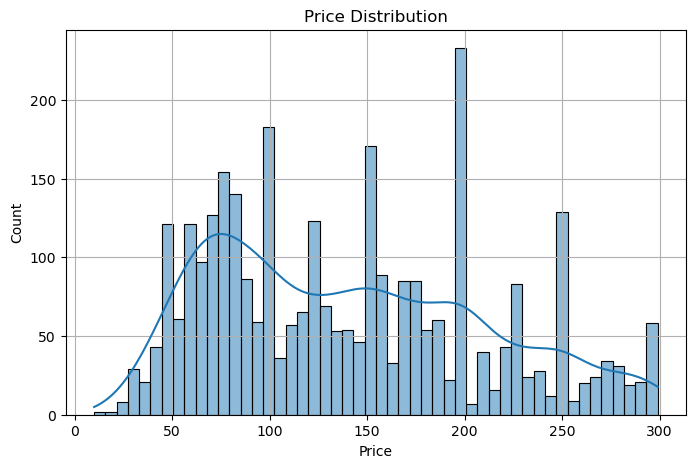

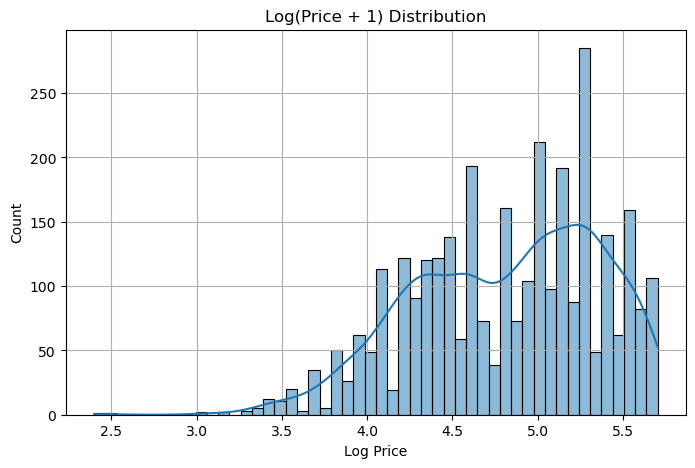

In [135]:
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Log-transformed
plt.figure(figsize=(8, 5))
sns.histplot(np.log1p(df['price']), bins=50, kde=True)
plt.title("Log(Price + 1) Distribution")
plt.xlabel("Log Price")
plt.ylabel("Count")
plt.grid(True)
plt.show()


The second graph, which shows the log-transformed price distribution, is better because it significantly reduces the right skew seen in the original price data. By compressing the range of high values, it creates a more symmetrical, bell-shaped distribution. This helps regression models learn more effectively, as they perform better when the target variable is closer to a normal distribution. It also reduces the impact of outliers, leading to more stable and accurate predictions across a wider range of prices.

#### 2. Numeric Features vs Price

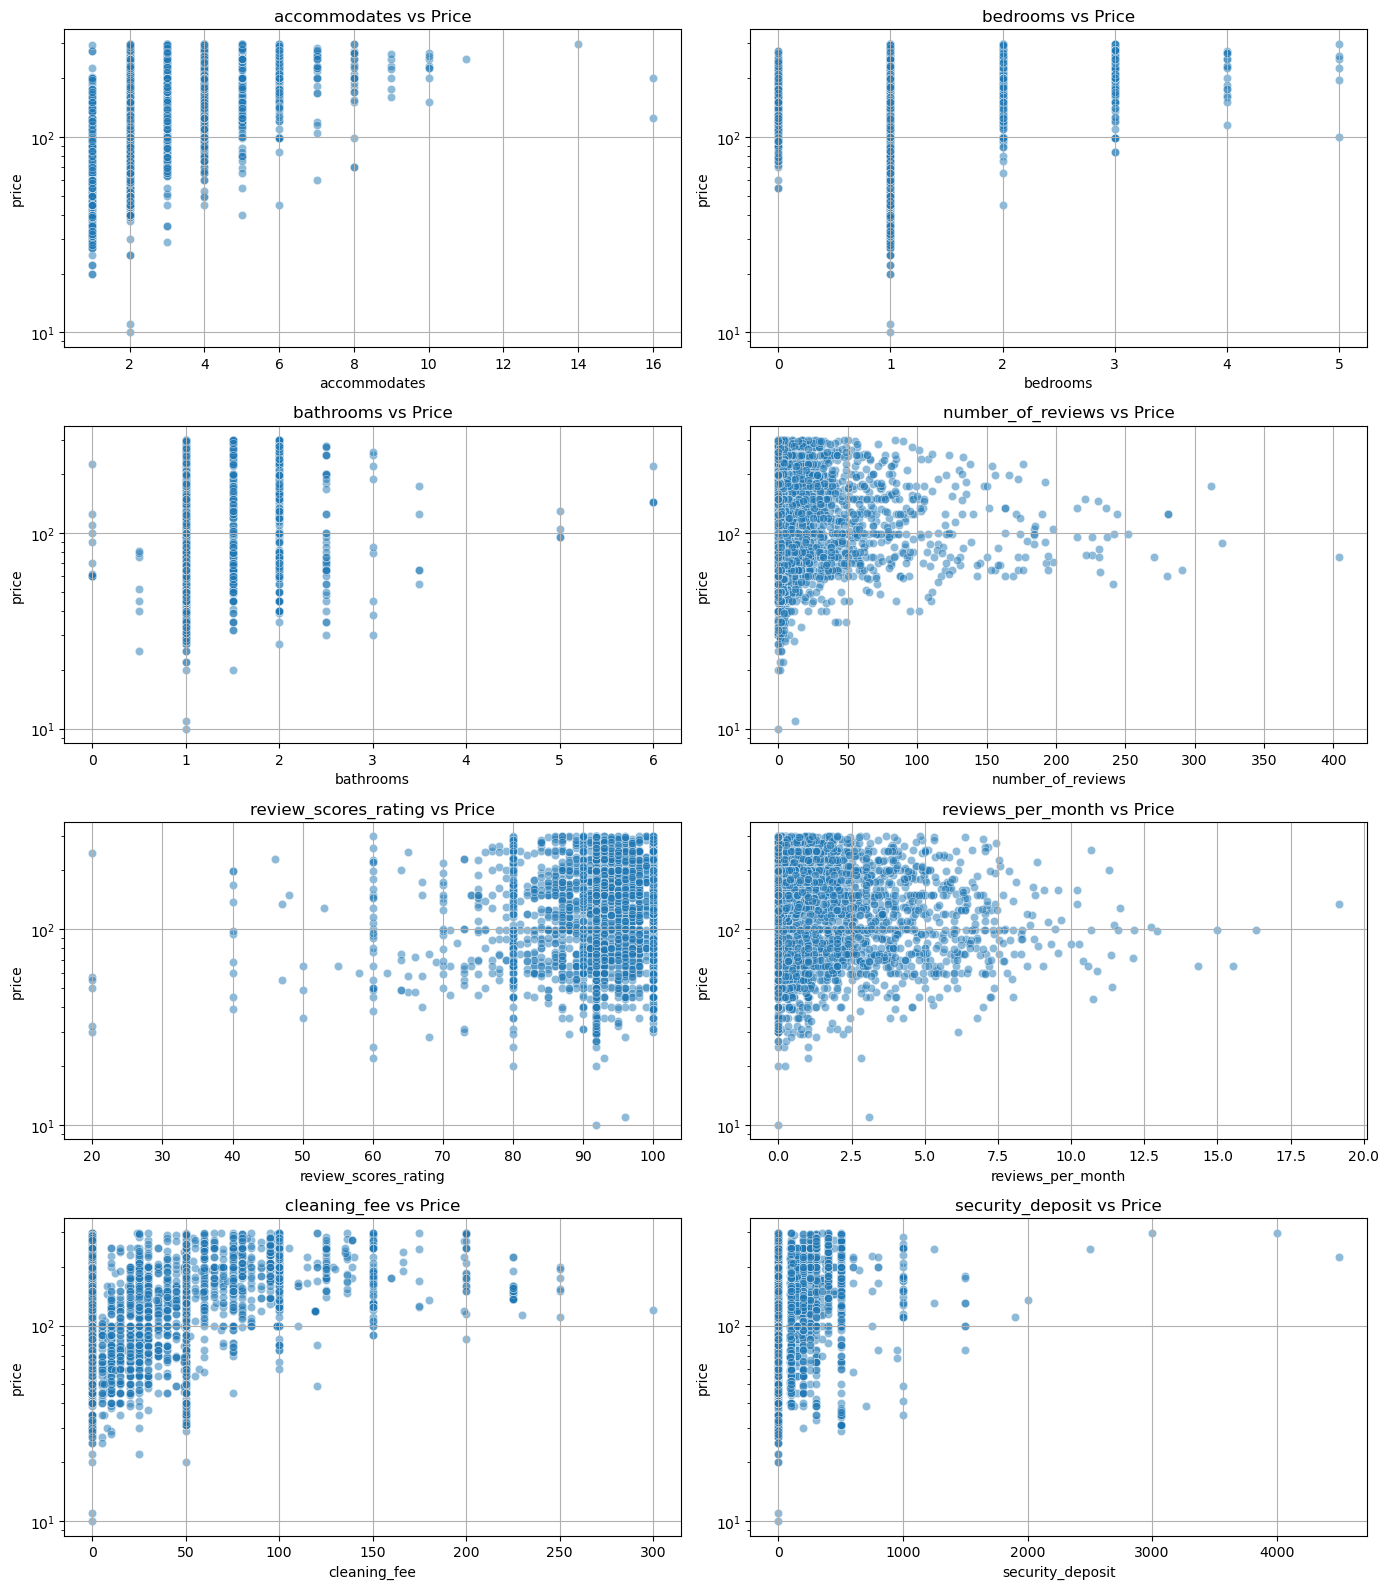

In [136]:
important_features = [
    "accommodates", "bedrooms", "bathrooms", "number_of_reviews",
    "review_scores_rating", "reviews_per_month",
    "cleaning_fee", "security_deposit"
]

cols = 2
rows = (len(important_features) + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 4))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Create scatter plots
for i, col in enumerate(important_features):
    sns.scatterplot(x=df[col], y=df['price'], ax=axes[i], alpha=0.5)
    axes[i].set_title(f"{col} vs Price")
    axes[i].set_yscale('log')
    axes[i].grid(True)

# Turn off empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


The scatter plots above visualize the relationship between key numeric features and the listing price. Overall, the distribution of points confirms several expected patterns, but also reveals important modeling challenges.

Features "accommodates", "bedrooms", "bathrooms" 
- They show a clear positive trend. As the number of guests or rooms increases, prices generally rise.

Features "number_of_reviews", "reviews_per_month"
- These have a weaker relationship with price, as they reflect listing popularity rather than value. Most listings have fewer than 100 reviews, with price variation visible at every review count.

Feature "review_scores_rating"
- Shows a subtle pattern where higher-rated listings tend to be priced slightly higher, but the effect is not dominant. Most prices concentrate in the 80–100 rating range.

Features "cleaning_fee", "security_deposit"
- Both show clearer upward trends with price, especially "cleaning_fee", which increases proportionally with overall listing price. security_deposit is often zero but when present, tends to be higher for expensive listings.



#### 3. Boxplot for categorical features

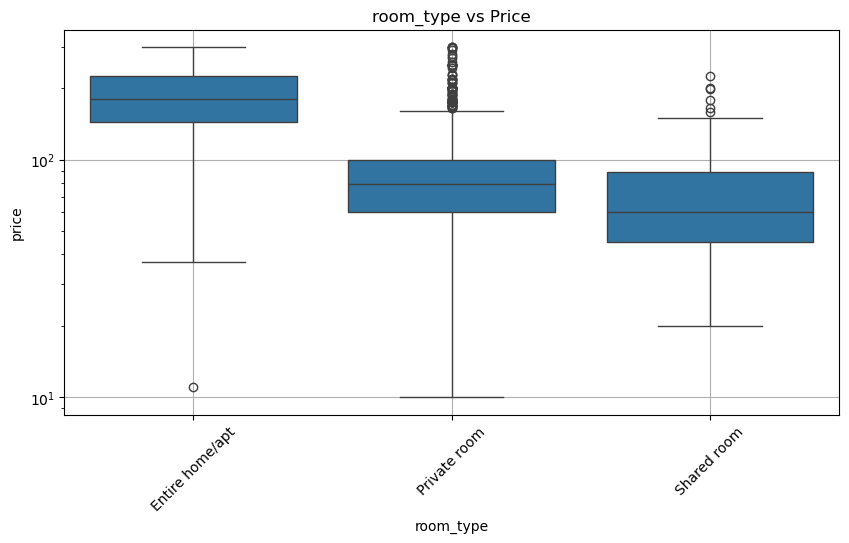

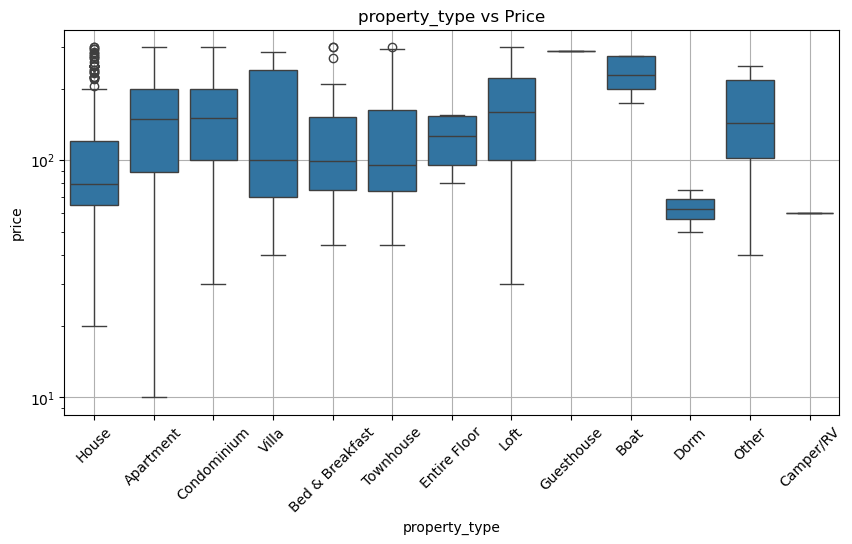

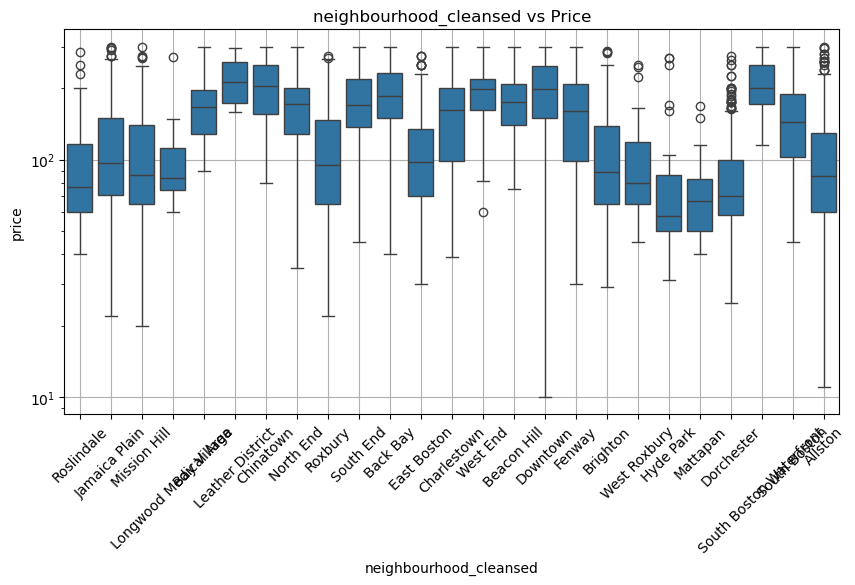

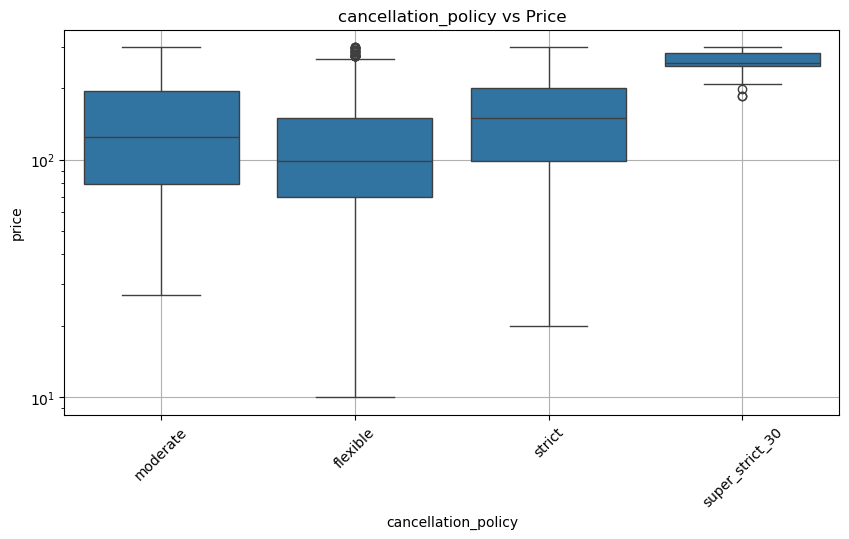

In [137]:
categorical_features = ['room_type', 'property_type', 'neighbourhood_cleansed', 'cancellation_policy']

for col in categorical_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=col, y='price', data=df)
    plt.xticks(rotation=45)
    plt.yscale('log')
    plt.title(f"{col} vs Price")
    plt.grid(True)
    plt.show()

Feature "room_type"
- Entire home/apt listings clearly have the highest median price and the widest price range.
- Private rooms are significantly more affordable and have lower variance.
- Shared rooms are the least expensive.

Feature "property_type"
- Villas, lofts, and boats show higher price medians, reflecting luxury or niche appeal.
- Dorms and guesthouses are the most affordable.

Feature "neighbourhood_cleansed"
- Neighborhoods like Bay Village, Back Bay, and Beacon Hill show higher median prices.
- Others like Dorchester and Hyde Park are consistently lower.

Feature "cancellation_policy"
- Listings with a super_strict_30 policy have the highest prices, suggesting they cater to higher-end guests or hosts with more confidence.
- Flexible and moderate policies are more common and tied to more affordable listings.

#### 4. Heatmap for Correlation Between Engineered Features

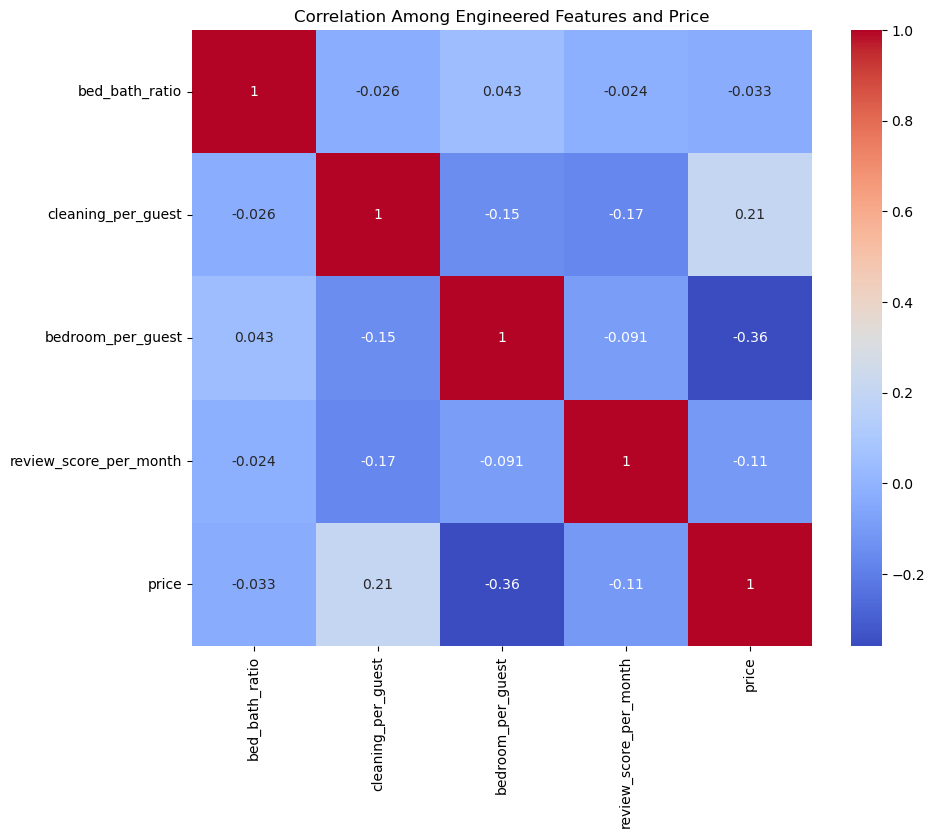

In [138]:
engineered = ['bed_bath_ratio', 'cleaning_per_guest', 'bedroom_per_guest', 'review_score_per_month']

plt.figure(figsize=(10, 8))
sns.heatmap(df[engineered + ['price']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Among Engineered Features and Price")
plt.show()


- Feature "cleaning_per_guest" shows a moderate positive correlation with price (0.21), suggesting that listings with higher cleaning fees relative to guest count tend to charge more overall.

- Feature "bedroom_per_guest" has the strongest negative correlation with price (-0.36). This may indicate that listings with fewer guests per bedroom actually have lower prices possibly due to small units with limited space.

- Feature "review_score_per_month" has a slightly negative correlation (-0.11) with price.

- Feature "bed_bath_ratio" show almost no correlation with price, indicating they may not contribute significantly to the model’s predictive power.

## __Features and Target splitting__

In [139]:
X = df.drop("price", axis=1)
y = np.log1p(df["price"])  # log transform target

## __Skewness Fixing__
Apply log1p to selected skewed numeric columns

In [140]:
log_features = [
    'number_of_reviews', 'reviews_per_month',
    'cleaning_fee', 'security_deposit',
    'bed_bath_ratio', 'cleaning_per_guest',
    'review_score_per_month'
]

for col in log_features:
    df[col] = np.log1p(df[col])

## __Preprocessing__


#### 1. Split numeric and categorical features

In [141]:
numeric_features = [
    "accommodates", "bedrooms", "bathrooms", "number_of_reviews",
    "review_scores_rating", "availability_30", "reviews_per_month",
    "cleaning_fee", "security_deposit", "bed_bath_ratio",
    "cleaning_per_guest", "host_is_superhost", "instant_bookable", "bedroom_per_guest",
    "review_score_per_month"
]

categorical_features = ["room_type", "property_type", "neighbourhood_cleansed", "cancellation_policy"]


#### 2. Apply scaling and One Hot Encoder

In [142]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),    # Scaling
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features) # One hot encoder
])

#### 3. Features and Target Splitting

In [143]:
X = df.drop("price", axis=1)
y = np.log1p(df["price"])  # log transform target

# Final X
X_processed = preprocessor.fit_transform(X)

#### 4. Train-Test Split

In [144]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)


## __Export new DataFrame__

In [145]:
# Get feature names from preprocessor (numeric + encoded categories)
numeric_names = numeric_features

# Get categorical encoded column names
cat_encoder = preprocessor.named_transformers_['cat']
cat_names = cat_encoder.get_feature_names_out(categorical_features)

# Combine all column names
all_feature_names = list(numeric_names) + list(cat_names)

# Convert to DataFrame
X_df_final = pd.DataFrame(X_processed, columns=all_feature_names)

# Add log-transformed price as target
X_df_final["log_price"] = y.values

# Save to CSV
X_df_final.to_csv("listings(preprocessed).csv", index=False)
print("Exported cleaned & model-ready dataset as 'listings(preprocessed).csv'")

Exported cleaned & model-ready dataset as 'listings(preprocessed).csv'


# __Linear Regression__

In [146]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

#### 1. Train Model

In [147]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

#### 2. Predict (log space)

In [148]:
y_pred_log_lr = lr.predict(X_test)

#### 3. Reverse log transform to get actual price predictions

In [149]:
y_pred_lr = np.expm1(y_pred_log_lr)
y_test_actual = np.expm1(y_test)

#### 4. Evaluate performance


In [150]:
lr_mse = mean_squared_error(y_test_actual, y_pred_lr)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test_actual, y_pred_lr)
lr_r2 = r2_score(y_test_actual, y_pred_lr)

#### 5. Print Results

In [151]:
print(f"Linear Regression Results:")
print(f" MSE: {lr_mse:.2f}")
print(f" RMSE: {lr_rmse:.2f}")
print(f" MAE: {lr_mae:.2f}")
print(f" R² Score: {lr_r2:.4f}")

Linear Regression Results:
 MSE: 1778.91
 RMSE: 42.18
 MAE: 31.06
 R² Score: 0.6003


# __Artificial Neural Network (ANN)__

In [152]:
from sklearn.neural_network import MLPRegressor

#### 1. Build the model

In [153]:
ann = MLPRegressor(
    hidden_layer_sizes=(240),
    activation='tanh',
    solver='adam',
    learning_rate_init=0.001,
    alpha=1e-4,
    max_iter=5000,
    early_stopping=True,
    n_iter_no_change=50,
    validation_fraction=0.2,
    random_state=42
)

#### 2. Train the model

In [154]:
ann.fit(X_train, y_train)

y_pred_log_ann = ann.predict(X_test)
y_pred_ann = np.expm1(y_pred_log_ann)
y_test_actual = np.expm1(y_test)

#### 3. Evaluate Performance

In [155]:
ann_mse = mean_squared_error(y_test_actual, y_pred_ann)
ann_rmse = np.sqrt(ann_mse)
ann_mae = mean_absolute_error(y_test_actual, y_pred_ann)
ann_r2 = r2_score(y_test_actual, y_pred_ann)

#### 4. Print results

In [156]:
print(f"ANN Results:")
print(f" MSE: {ann_mse:.2f}")
print(f" RMSE: {ann_rmse:.2f}")
print(f" MAE: {ann_mae:.2f}")
print(f" R² Score: {ann_r2:.4f}")

ANN Results:
 MSE: 1625.41
 RMSE: 40.32
 MAE: 29.19
 R² Score: 0.6348


# __Deep Neural Network (DNN)__

In [157]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

#### 1. Build the model

In [158]:
from tensorflow.keras.regularizers import l2

dnn = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(220, activation='tanh'),
    Dropout(0.15),
    Dense(128, activation='tanh'),
    Dropout(0.15),
    Dense(64, activation='tanh'),
    Dropout(0.1),
    Dense(1)
])


dnn.compile(
    optimizer=Adam(learning_rate=0.002),
    loss='mse',
    metrics=['mae']
)

#### 2. Train model

In [159]:
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)

history = dnn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

y_pred_log_dnn = dnn.predict(X_test).flatten()
y_pred_dnn = np.expm1(y_pred_log_dnn)
y_test_actual = np.expm1(y_test)

Epoch 1/1000
32/32 - 1s - 40ms/step - loss: 5.3484 - mae: 1.7670 - val_loss: 0.6554 - val_mae: 0.6461 - learning_rate: 0.0020
Epoch 2/1000
32/32 - 0s - 4ms/step - loss: 0.4711 - mae: 0.5347 - val_loss: 0.1579 - val_mae: 0.3095 - learning_rate: 0.0020
Epoch 3/1000
32/32 - 0s - 4ms/step - loss: 0.3223 - mae: 0.4492 - val_loss: 0.1185 - val_mae: 0.2712 - learning_rate: 0.0020
Epoch 4/1000
32/32 - 0s - 4ms/step - loss: 0.2693 - mae: 0.4106 - val_loss: 0.1083 - val_mae: 0.2468 - learning_rate: 0.0020
Epoch 5/1000
32/32 - 0s - 4ms/step - loss: 0.2923 - mae: 0.4280 - val_loss: 0.0957 - val_mae: 0.2381 - learning_rate: 0.0020
Epoch 6/1000
32/32 - 0s - 4ms/step - loss: 0.2561 - mae: 0.4060 - val_loss: 0.0904 - val_mae: 0.2308 - learning_rate: 0.0020
Epoch 7/1000
32/32 - 0s - 4ms/step - loss: 0.2449 - mae: 0.3917 - val_loss: 0.0900 - val_mae: 0.2254 - learning_rate: 0.0020
Epoch 8/1000
32/32 - 0s - 4ms/step - loss: 0.2339 - mae: 0.3803 - val_loss: 0.0942 - val_mae: 0.2387 - learning_rate: 0.0020

#### 3. Evaluate

In [160]:
dnn_mse = mean_squared_error(y_test_actual, y_pred_dnn)
dnn_rmse = np.sqrt(dnn_mse)
dnn_mae = mean_absolute_error(y_test_actual, y_pred_dnn)
dnn_r2 = r2_score(y_test_actual, y_pred_dnn)

#### 4. Print results

In [161]:
print(f"DNN Results:")
print(f" MSE: {dnn_mse:.2f}")
print(f" RMSE: {dnn_rmse:.2f}")
print(f" MAE: {dnn_mae:.2f}")
print(f" R² Score: {dnn_r2:.4f}")

DNN Results:
 MSE: 1555.37
 RMSE: 39.44
 MAE: 29.83
 R² Score: 0.6506


# __Visualize Results__


Scatter plot for comparing
- LR with y_test
- MLP with y_test
- DNN with y_test

In [162]:
import matplotlib.pyplot as plt

# Make sure y_test is 1D
y_test_array = y_test.to_numpy().ravel() if hasattr(y_test, "to_numpy") else y_test.ravel()

#### 1. Linear Regression

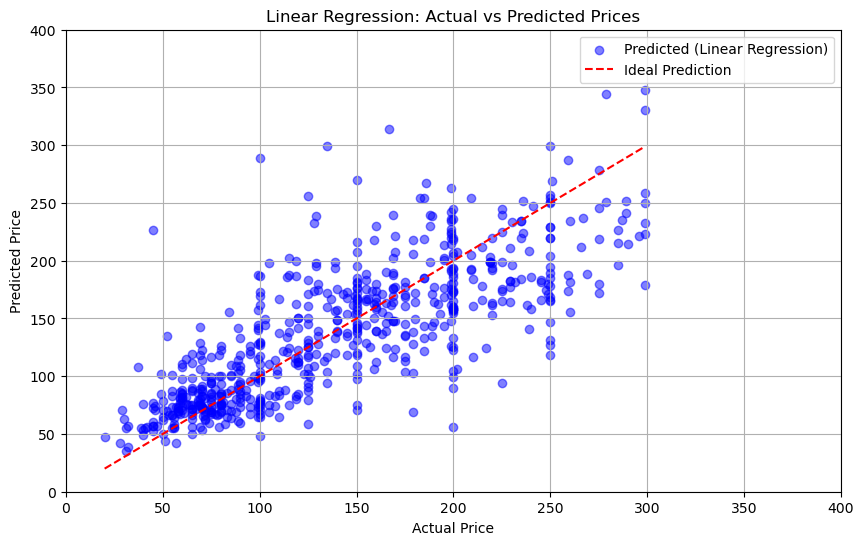

In [163]:
# Predict in log space
y_pred_log_lr = lr.predict(X_test)

# Convert predictions & actual back to original scale
y_pred_lr = np.expm1(y_pred_log_lr)
y_test_actual = np.expm1(y_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, y_pred_lr, alpha=0.5, color='blue', label='Predicted (Linear Regression)')
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         'r--', label='Ideal Prediction')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Linear Regression: Actual vs Predicted Prices")
plt.legend()
plt.grid(True)
plt.xlim(0, 400)
plt.ylim(0, 400)
plt.show()


The predictions from the Linear Regression model show a wide spread from the ideal diagonal line, especially at higher price ranges. This indicates underfitting, where the model struggles to capture the complex pricing patterns. Many predictions fall short or overshoot the actual prices, reflecting limited predictive power.

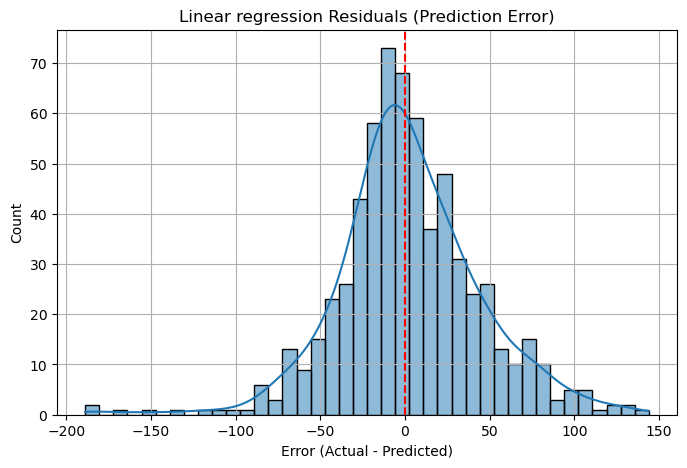

In [164]:
residuals = y_test_actual - y_pred_lr

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=40, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Linear regression Residuals (Prediction Error)")
plt.xlabel("Error (Actual - Predicted)")
plt.grid(True)
plt.show()

The residuals are spread out unevenly and show a slight skew, indicating prediction errors are not uniformly distributed. There's a noticeable number of high-magnitude errors, particularly underestimations. This further confirms that the Linear Regression model lacks accuracy and consistency.

#### 2. Artificial Neural Network (ANN)

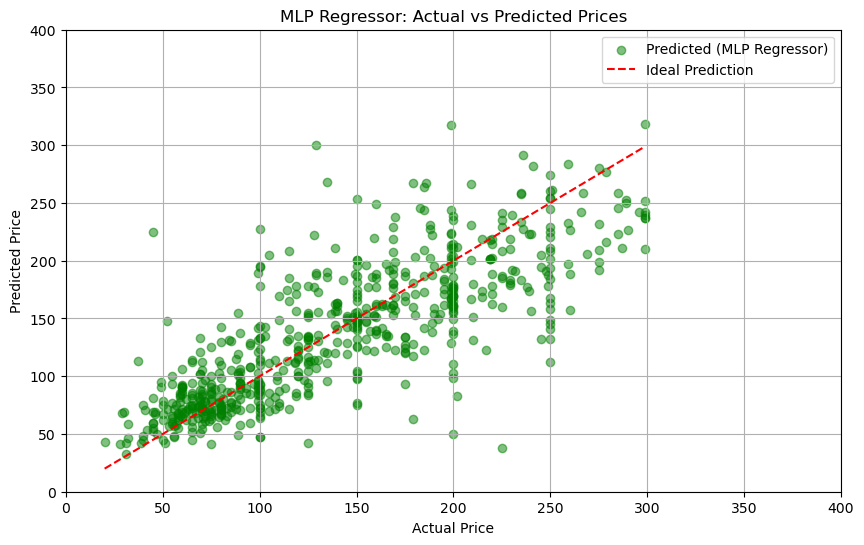

In [165]:
# MLP Regressor Plot 

y_pred_log_mlp = ann.predict(X_test)
y_pred_mlp = np.expm1(y_pred_log_mlp)

plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, y_pred_mlp, alpha=0.5, color='green', label='Predicted (MLP Regressor)')
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         'r--', label='Ideal Prediction')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("MLP Regressor: Actual vs Predicted Prices")
plt.legend()
plt.grid(True)
plt.xlim(0, 400)
plt.ylim(0, 400)
plt.show()

The ANN model shows better alignment than Linear Regression, with more predictions clustering near the ideal line. However, there's still some visible deviation, especially in higher-price regions. While improved, the scatter plot suggests the ANN model may not be fully optimized or has limited depth.

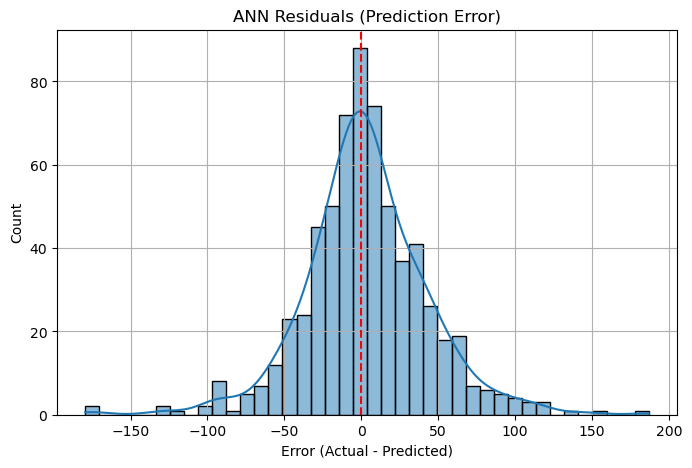

In [166]:
residuals = y_test_actual - y_pred_ann

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=40, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("ANN Residuals (Prediction Error)")
plt.xlabel("Error (Actual - Predicted)")
plt.grid(True)
plt.show()

The residuals are more centered compared to Linear Regression, with a sharper peak near zero. However, some spread remains, indicating that prediction errors still exist, especially on the higher side. This supports that the ANN model performs better but still has room for improvement.

#### 3. Deep Neural Network

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


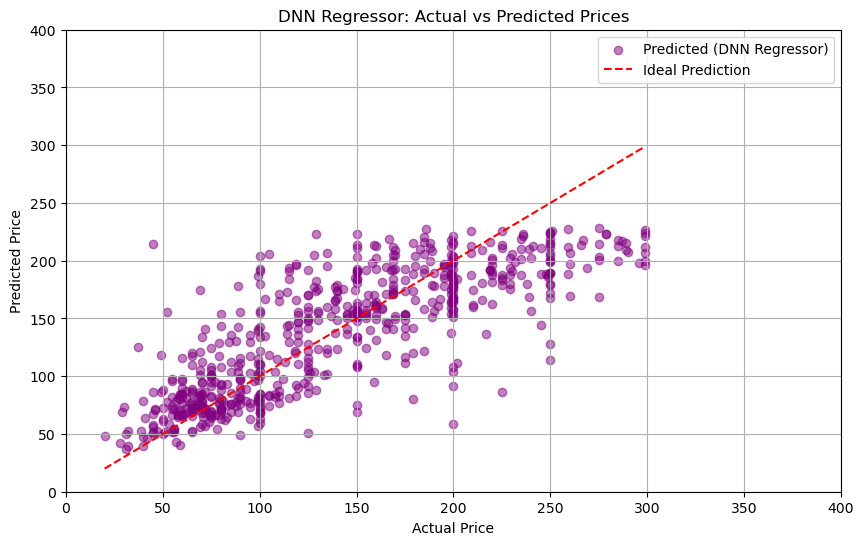

In [167]:
# DNN Regressor Plot

y_pred_log_dnn = dnn.predict(X_test).flatten()
y_pred_dnn = np.expm1(y_pred_log_dnn)

plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, y_pred_dnn, alpha=0.5, color='purple', label='Predicted (DNN Regressor)')
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         'r--', label='Ideal Prediction')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("DNN Regressor: Actual vs Predicted Prices")
plt.legend()
plt.grid(True)
plt.xlim(0, 400)
plt.ylim(0, 400)
plt.show()

The DNN model demonstrates the strongest visual performance, with predictions tightly clustered around the ideal prediction line. The alignment is consistent across most price ranges, indicating the model successfully captures the complex, non-linear patterns in the dataset.

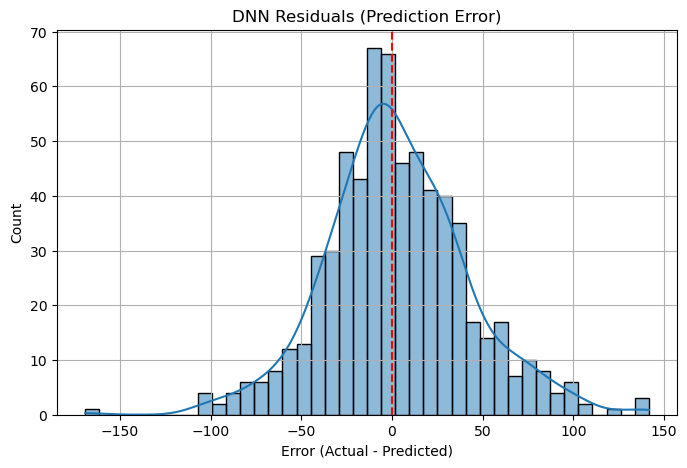

In [168]:
residuals = y_test_actual - y_pred_dnn

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=40, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("DNN Residuals (Prediction Error)")
plt.xlabel("Error (Actual - Predicted)")
plt.grid(True)
plt.show()

Residuals from the DNN model are tightly grouped around zero with minimal skew, forming a near-normal distribution. This confirms the model’s stability and accuracy, with fewer extreme errors compared to both ANN and Linear Regression.

# __Findings__

## Model Performance Summary

We evaluated and compared three regression models: **Linear Regression**, **ANN Model** and **DNN Model** to predict Airbnb listing prices. After applying log transformation on the target variable and reverse-transforming the predictions back to the original price scale, the following insights were observed:

In [169]:
metrics = {
    "Metric": ["MSE", "RMSE", "MAE", "R² Score"],
    "Linear Regression": [f"{lr_mse:.3f}", f"{lr_rmse:.3f}", f"{lr_mae:.3f}", f"{lr_r2:.3f}"],
    "MLP Regressor": [f"{ann_mse:.3f}", f"{ann_rmse:.3f}", f"{ann_mae:.3f}", f"{ann_r2:.3f}"],
    "DNN Regressor": [f"{dnn_mse:.3f}", f"{dnn_rmse:.3f}", f"{dnn_mae:.3f}", f"{dnn_r2:.3f}"]
}

metrics_df = pd.DataFrame(metrics).astype(str)

from tabulate import tabulate
print(tabulate(metrics_df, headers="keys", tablefmt="github", showindex=False))


| Metric   |   Linear Regression |   MLP Regressor |   DNN Regressor |
|----------|---------------------|-----------------|-----------------|
| MSE      |            1778.91  |        1625.4   |        1555.37  |
| RMSE     |              42.177 |          40.316 |          39.438 |
| MAE      |              31.055 |          29.19  |          29.826 |
| R² Score |               0.6   |           0.635 |           0.651 |


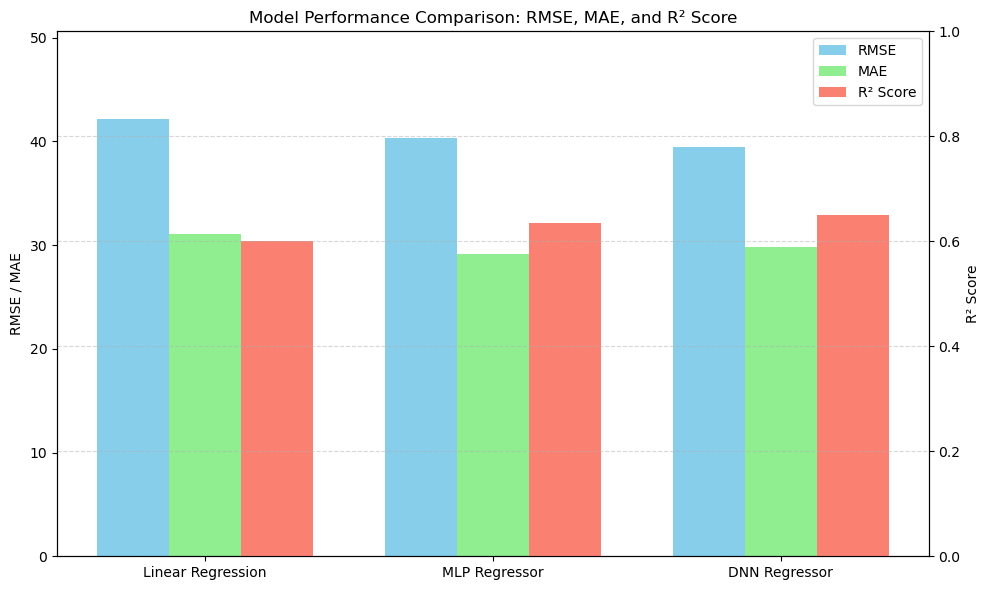

In [170]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Linear Regression', 'MLP Regressor', 'DNN Regressor']
x = np.arange(len(models))          

rmse_values = [lr_rmse,  ann_rmse,  dnn_rmse]
mae_values  = [lr_mae,   ann_mae,   dnn_mae]
r2_values   = [lr_r2,    ann_r2,    dnn_r2]

assert len(rmse_values) == len(models) == len(mae_values) == len(r2_values), \
       "Metric arrays must be the same length as 'models'!"

fig, ax1 = plt.subplots(figsize=(10, 6))
bar_width = 0.25                   

bars_rmse = ax1.bar(x - bar_width,        rmse_values, width=bar_width,
                    color='skyblue',  label='RMSE')
bars_mae  = ax1.bar(x,                     mae_values,  width=bar_width,
                    color='lightgreen', label='MAE')
ax1.set_ylabel('RMSE / MAE')
ax1.set_ylim(0, max(max(rmse_values), max(mae_values)) * 1.2)

ax2 = ax1.twinx()
bars_r2  = ax2.bar(x + bar_width,         r2_values,   width=bar_width,
                   color='salmon',   label='R² Score')
ax2.set_ylabel('R² Score')
ax2.set_ylim(0, 1)

plt.xticks(x, models, rotation=10)
plt.title("Model Performance Comparison: RMSE, MAE, and R² Score")

handles = [bars_rmse[0], bars_mae[0], bars_r2[0]]
labels  = ['RMSE', 'MAE', 'R² Score']
ax1.legend(handles, labels, loc='upper right')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Visual Comparison

- The DNN Regressor clearly outperforms the other models in terms of error minimization. Both its RMSE and MAE are the lowest, which is visually represented by the shortest bars in the error metric plots. This indicates that the DNN model not only makes more accurate predictions but is also more consistent in minimizing large errors.

- It also leads with the highest R² score, suggesting that it captures a greater portion of the variance in actual price values. This reinforces the DNN’s superiority in predictive power and generalization ability compared to the others.

- The ANN Regressor (ANN), although slightly better than Linear Regression in MSE and RMSE, did not surpass it in stability or overall performance. Its MAE is the lowest, but its R² is just 0.617, only marginally higher than LR. The error bars for MLP appear higher than expected, which may hint at suboptimal network depth, ineffective regularization, or early stopping before full convergence.

- Linear Regression, while the simplest model, performed surprisingly well. It achieved a respectable R² of 0.597, outperforming the MLP in error consistency. Its smaller error bars compared to MLP show that it maintained better stability across predictions despite lacking the complexity of neural architectures.

### Deep Neural Network (DNN) shows the strongest visual alignment

We included the DNN model alongside Linear Regression and ANN to evaluate whether a deeper network would improve prediction quality.

- The scatter plot for the DNN model reveals the closest alignment to the ideal diagonal line compared to both Linear Regression and ANN.
- Predictions made by the DNN were more consistent and showed less spread, even at higher price points.
- This indicates that the deeper architecture of the DNN allowed it to capture more complex, non-linear relationships in the data.
- Overall, the DNN scatter plot visually confirms the superior performance seen in its evaluation metrics, especially in terms of accuracy and generalization.


## Key Takeaways

- DNN Regressor emerged as the top performer, achieving the lowest RMSE and MAE, along with the highest R² score. Its deeper architecture allowed it to learn complex, non-linear relationships in the dataset, making it the most consistent and accurate model overall.

- ANN Regressor underperformed expectations. Despite being more complex than Linear Regression, it showed higher errors, likely due to poor convergence or insufficient tuning. This suggests that architecture and training dynamics heavily impact ANN performance.

- Linear Regression provided baseline reliability, performing moderately well but lacking the capacity to model intricate feature interactions. Its limitations in handling non-linear patterns were clearly evident when compared to the deep learning models.

- Log transformation of the target variable (price) was crucial across all models. It significantly improved error metrics, especially for the DNN, which benefited from a more normalized target distribution and deeper learning capacity. This preprocessing step proved essential for handling the skewed nature of real-world pricing data.

## Limitations and Next Steps

### Limitations

#### 1. Linear Regression's Simplicity Limits Learning
While useful as a baseline, Linear Regression failed to model the complex, non-linear patterns present in Airbnb pricing. Its inability to capture interactions among features limited its predictive accuracy.

#### 2. ANN Underperformance Despite Complexity
Although the ANN model was deeper than Linear Regression, its performance gain was marginal. This may indicate issues with suboptimal architecture, insufficient training, or lack of proper regularization techniques.

#### 3. Outliers and Skewed Price Distribution
All models showed noticeable errors on high-priced listings. Despite using a log transformation, extreme values still impacted performance, especially for simpler models.

#### 4. Feature Limitations
Several potential features (e.g., geographical coordinates, review sentiment, amenities richness) were not included. This may have restricted the models’ ability to fully learn price-driving factors.

#### 4. Training Stability for DNNs
DNNs showed the best performance, but they required careful tuning (e.g., learning rate scheduling, early stopping). Training was computationally expensive and time-consuming

### Next Steps

#### 1. Improve ANN Model Design
Experiment with alternative architectures (e.g., more hidden layers or dropout) and training strategies (e.g., batch normalization, different activation functions) to boost performance

#### 2. Enhance Feature Set
Introduce location-based features (e.g., latitude/longitude clustering), review sentiment scores, and interaction terms to give the models more pricing context.

#### 3. Outlier Treatment and Robust Regression
Apply advanced outlier detection or robust regression methods (e.g., Huber Regression or quantile loss) to reduce the effect of extreme price values.

#### 4. Cross-Validation for Robust Evaluation
Apply k-fold cross-validation to validate model stability across different splits and avoid results based on a single train/test combination.

#### 5. Ensemble Approaches
Combine models (e.g., DNN + Random Forest or Gradient Boosting) to leverage both non-linear modeling and interpretability.